In [1]:
from nilmtk import DataSet
from matplotlib import rcParams
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import h5py
import datetime
import warnings
import matplotlib.pyplot as plt
from pyts.image import GramianAngularField
from pyts.image import RecurrencePlot

import itertools as it


#TODO create a folder with utils and split modules there

#print module
#file module
#setup module
#process module 
from utils import print_parameters, print_log
from utils import create_file, create_hdf5_group, store_single_hdf5, store_many_hdf5, read_many_hdf5
from utils import get_appliances, get_good_sections, get_clean_data, trasfrom_ts, append_images

plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 10)
plt.figure(figsize=(10,30))

dataset_name = "iawe"
dataset = DataSet('datasets/'+dataset_name+'.h5')
dataset.set_window()


Bad key "text.kerning_factor" on line 4 in
/Users/jakob/anaconda3/envs/nilmtk-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/Users/jakob/anaconda3/envs/nilmtk-env/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


HDF5ExtError: HDF5 error back trace

  File "H5F.c", line 509, in H5Fopen
    unable to open file
  File "H5Fint.c", line 1567, in H5F_open
    unable to lock the file
  File "H5FD.c", line 1640, in H5FD_lock
    driver lock request failed
  File "H5FDsec2.c", line 959, in H5FD_sec2_lock
    unable to lock file, errno = 35, error message = 'Resource temporarily unavailable'

End of HDF5 error back trace

Unable to open/create file 'datasets/iawe.h5'

# TIMESERIES TO IMAGE CONVERTER


In [4]:
def mount_data(meter: pd.DataFrame) -> np.ndarray:
    """ 
        Reads data from dataframe generator and resamples it to 6s.
        In case active power cannot be mounted, it warns user and mounts apparent power. 
    """
    #read power data and write it to timeseries 

    df = next(meter.load(physical_quantity='power'))

    # possible implementation with bigger output
    #df = df.resample('6s').bfill(limit=2)

    df = df.resample("6s").asfreq()

    tstamps = df.index.view(np.int64)//10**9

    try:
        ts = df.power.active.values.transpose()
    except:
        print("no active power!")
        print_log("no active power!")
        
        try:
            print("using apparent power!")
            print_log("using apparent power!")
            
            ts = df.fillna(0).power.apparent.values.transpose()
        
        except:
            print("no apparent power!")
            print_log("no apparent power!")
            
            raise ValueError
    
    return [ts, tstamps]

def all_equal(sig: np.ndarray) -> bool:
    """
        Checks if elements in input array are all equal. 
    """
    return True if np.min(sig)-np.max(sig) == 0 else False
    

def moving_window(x:np.ndarray, length:int, step:int=1) -> np.ndarray:
    """
        Slices input x to specified length and step. Remainder is dicarded. 
    """
    streams = it.tee(x, length)
    
    return np.asarray(list(zip(*[it.islice(stream, i, None, step*length) for stream, i in zip(streams, it.count(step=step))])))
     

def percent_nan(sig:np.ndarray) -> int:  
    """
        Return percent of missing data. 
    """  
    return (np.count_nonzero(~np.isnan(sig))/sig.shape[0])


def fill_missing(sig:np.ndarray) -> np.ndarray:
    """
        Fill missing data first with backfill,then with forwardfill, finally convert to list and return it.
    """
    return np.asarray(pd.Series(sig).bfill().ffill().tolist())



def filter_empty_slices_and_fill_missing_samples(signal_slices:np.ndarray, time_stamp_slices:np.ndarray, par: dict) -> np.ndarray:
    """
    Loop trough slices of signal data and remove data that has less that par["missing_data_allowed"], if more fill NaNs with bfill and ffill. 

    :param: slignal_slices - np.array of singal slices
    :param: time_stamp_slices - np.arrat of slices of time stamps

    :return: signal_out, time_stamp_out - tuple of [np.ndarray np.ndarray] of processed slices
    """
    try:
        signal_out, time_stamp_out =  zip(*[(fill_missing(sig), stamp) for sig, stamp in zip(signal_slices, time_stamp_slices) if percent_nan(sig) > par["percentage_of_missing_data_allowed"] ])

    except ValueError:
        # in case when nothing to return, list comprehension returns ValueError
        signal_out, time_stamp_out = ([],[])

    except: raise

    return np.asarray(list(signal_out)), np.asarray(list(time_stamp_out))

def filter_low_entropy_slices(signal_slices: np.ndarray, time_stamp_slices: np.ndarray, par: dict):
    """ 
    Removes slices with power less than 10W and slices that have all samples of the same value. 
    """
    try:
        signal_out, time_stamp_out =  zip(*[[sig,stamp] for sig, stamp in zip(signal_slices, time_stamp_slices) if not all_equal(sig) and np.any(sig > 10) ])
        
    except ValueError:
        # in case when nothing to return, list comprehension returns ValueError
        signal_out, time_stamp_out = ([],[])
        
    except: raise

    return np.asarray(list(signal_out)), np.asarray(list(time_stamp_out))

def print_progress(i, signal_slices, img_stack, print_flag, par):
    """
    Prints current progress of transfomation every 10 %.
    """
    if round(100*i/(signal_slices.shape[0]),2) > print_flag:
        print_flag += 10

        print("procesed: "f"{round(100*i/(signal_slices.shape[0]),2)}% finished: "f"{round(100*((img_stack.shape[0])/par['max_images']),2)}%")
        print_log(par,"procesed: "f"{round(100*i/(signal_slices.shape[0]),2)}% finished: "f"{round(100*((img_stack.shape[0])/par['max_images']),2)}%")
    
    return print_flag


def print_break(par):
    """
    Informs user that maximum number of images has been reached. 
    """
    print("max size of "f"{par['max_images']}"" reached, skipping!")   
    print_log(par,"max size of "f"{par['max_images']}"" reached, skipping!")

def print_begin_appliance(appliance,par):
    """
    Informs user what appliance will script be processing. 
    """
    print_log(par,"\n")
    print_log(par," Starting " f"{appliance} ("+str(par["appliances"].index(appliance)+1)+"/"+str(len(par["appliances"]))+"):")
    print("\n")
    print(" Starting " f"{appliance} ("+str(par["appliances"].index(appliance)+1)+"/"+str(len(par["appliances"]))+"):")

def print_begin_building(building,par):
    """
    Informs user which building will scripb be processing. 
    """
    print("Starting building ",building)
    print_log(par,"\n")
    print_log(par,"Starting building "f"{building}")

def print_end_of_loop(images_stacked,appliance,par):
    """
    Informs user that script has reached end of loop.
    """
    print_log(par,"")
    print_log(par,"number of images (per appliance) stacked: "f"{images_stacked}")
    print("")
    print("number of images (per appliance) stacked: "f"{images_stacked}")

    print_log(par,"finished "f"{appliance}")
    print("finished "f"{appliance}")
    
    print("\n")
    print_log(par,"\n")

def print_end(all_images_stacked,healthy_appliances,par):
    """
    Informs user that script has come to an end.  
    """
    print_log(par,"num of images stored: ", all_images_stacked)
    print("num of images stored: ", all_images_stacked)
    print_log(par,"appliances stored: ", healthy_appliances)
    print("appliances stored: ", healthy_appliances)

def param_setup(dataset,par):
    """
    Sets up and fixes possible misconfiguration.
    """
    #get params from metadata 
    par["dataset_name"] = dataset.metadata["name"].lower()
    par["n_buildings"] = len(dataset.buildings)

    #calculate time esitmated size of time series
    par["ts_size"] = round(par["step_in_mins"]*60/par["sample_period"])

    #fix parms 
    #RECU already includes brightness 
    if par["trs_type"] == "RECU": par["add_brightness"] = False

    if par["multiple_buildings"]: par["selected_building"] = "A"
        
    #handle edge case for RECU
    par["org_img_size"] = par["img_size"]

    if par["trs_type"] == "RECU": par["img_size"] = par["ts_size"] 



# meter = dataset.buildings[1].elec.submeters().meters[6]
# print(meter.appliances[0].metadata.get("type"),meter.on_power_threshold())

# signal,time_stamps = mount_data(meter)

# time_stamp_slices = moving_window(time_stamps, 130)
# signal_slices = moving_window(signal, 130)

# signal_slices, time_stamp_slices = filter_empty_slices_and_fill_missing_samples(signal_slices, time_stamp_slices)

# print(signal_slices.shape, time_stamp_slices.shape)

# signal_slices, time_stamp_slices = filter_low_entropy_slices(signal_slices, time_stamp_slices)

# print(signal_slices.shape, time_stamp_slices.shape)

# try:
#     ts,tstamps = remove_empty(ts,tstamps)
# except:
#     print("array empty!")

# ts= np.asarray(list(ts))
# tstamps = np.asarray(list(tstamps))

# print(ts.shape)g

# print("percent high d",100*count[2]/count[1])

# print("percent lost due to jump ",100*count[4]/count[0])
# print("percent lost due to enropy ",100*count[3]/count[0])

In [ ]:
par = {
'step_in_mins': 13, 
 'max_images': 1000, # number of images per appliance per building
 'img_size': 100, # output image size
 'frames': 5, # video frames
 'allowed_delta_between_frames': 600, # allowed time difference between frames
 'sample_period': 6,
 'percentage_of_missing_data_allowed': 0.95,
 'add_brightness': True,
 'ts_save': False,
 'trs_type': 'GAF',
 'trs_type_gaf': 'GASF',
 'multiple_buildings': True,
 'selected_building': 1,
 'manauly_select_appliances': False
}

In [5]:
#--PARAMTERS--#   
#-step
# make a dictionary
par = {}
par["step_in_mins"]= 13 
#-image
par["max_images"] = 1000 #max number of images per appliance per buidling 
par["img_size"] = 100 # means img_size x img_size (igored when using RECC)
par["frames"] = 5 #change to 0 for images or set more for video  
par["allowed_delta_between_images"] = 600*1 #allowed missing seconds between images in video (6 seconds is mimimum)

#-samples
par["sample_period"] = 6 # can be obtained from dataset.metadata["sample_period"] but it is inconsistent
par["percentage_of_missing_data_allowed"] = 0.95 # is necessary since sampling rate is inconsistent or samples are missing 

#-brightness
par["add_brightness"] = True

#-timeseries
par["ts_save"] = False # save soruce time-series 

#-trans type
par["trs_type"] = "GAF" #GAF or RECU - Gramian Angural Field or Recurrance plot

#-if trans type GAF 
par["trs_type_gaf"] = "GASF" # GASF or GADF

#-buildings
par["multiple_buildings"] = True # multiple buildings 
par["selected_building"] = 1 # is used in case parameter multiple buidlings is False

#-appliances
par["manauly_select_appliances"] = False
#-------------------------------------------------------------------------------------------------------------------------------
  
#initialize 
param_setup(dataset,par)
#maybe return appliances #TODO 
get_appliances(dataset,par)
print_parameters(par)
file_name = create_file(par)

# define global metrics
healthy_appliances = set()
images_stacked = 0 
images_stacked_per_appliance = 0 

# collect at least N images of "max_dataset_size" for each applaiance for every building. #TODO 
for appliance in par["appliances"]:
    print_begin_appliance(appliance,par)

    # define metric
    images_stacked_per_appliance = 0
    
    # loop through all buildings 
    for building in dataset.buildings:
        print_begin_building(building,par)

        # define temporary array to store image / frame 
        img_stack_tmp = np.zeros([0, par["img_size"], par["img_size"]])
        sig_stack_tmp = np.zeros([0, par["ts_size"]])
        
        # define main array to store video
        img_stack = np.zeros([0, par["frames"], par["img_size"], par["img_size"]])
        sig_stack = np.zeros([0, par["frames"], par["ts_size"]])

        # case if using only selected building
        if par["multiple_buildings"] == False:
                if int(building)  != par["selected_building"]:
                    print("skipping building "f"{building}"" due to parameter muliple_buildings ")
                    continue
        
        # filter out appliances with appliance
        for meter in dataset.buildings[building].elec.submeters().meters:  
            
            # get appliance name 
            label = meter.appliances[0].metadata.get("type")
            
            # continue only for applaiance from first loop
            if label != appliance : continue 

            # load data into RAM
            signal,time_stamps = mount_data(meter)

            # slice timestamps and signal data to specified length
            time_stamps_slices = moving_window(time_stamps, par["ts_size"])
            signal_slices = moving_window(signal, par["ts_size"])

            # filter out data that is not needed
            signal_slices, time_stamps_slices = filter_empty_slices_and_fill_missing_samples(signal_slices, time_stamps_slices, par)
            signal_slices, time_stamps_slices = filter_low_entropy_slices(signal_slices, time_stamps_slices, print_parameters)
            
            # continue if no data
            if signal_slices.shape[0] == 0: continue
        
            print("Finished pre-processing! transforming...")

            #define metrics 
            last_stamp = 0 # used in append_images for calculating delta
            print_flag = 10 # variable helps reduce log output in print_progress 

            # trasform pre-processed signal slices 
            for i, [sig, time_stamps] in enumerate(zip(signal_slices, time_stamps_slices)):
                
                print_flag = print_progress(i, signal_slices, img_stack, print_flag, par)

                # stop looping if enough data
                if img_stack.shape[0] >= (par["max_images"]):
                    print_break(par)
                    break
                
                sig, img = trasfrom_ts(sig, par)
                    
                #append trasformed ts
                img_stack, img_stack_tmp, sig_stack, sig_stack_tmp, last_stamp = append_images(img, img_stack, img_stack_tmp,
                                                                                               sig, sig_stack, sig_stack_tmp,
                                                                                               time_stamps, last_stamp, par) 
        
        if img_stack.shape[0] > 0:
            # save images to hdf5
            group_path = f"{par['dataset_name']}/"f"{appliance}/"f"{building}"
        
            store_many_hdf5(file_name, img_stack[...,np.newaxis], group_path, "img", force_del="yes")
            
            images_stacked_per_appliance += img_stack.shape[0]
            images_stacked += img_stack.shape[0]
            healthy_appliances.add(appliance)
            
            if par["ts_save"]:
                #save source time series 
                store_many_hdf5(file_name, sig_stack, group_path, "sig", force_del="yes")

        else:
            print("empty for building", building, "appliance", appliance)
  
        print("finished building N", building)
        print_log(par, "finished building N", building)
    
    print_end_of_loop(images_stacked_per_appliance, appliance, par)
    
print_end(images_stacked, healthy_appliances, par)

file exists!


 Starting clothes iron (1/9):
Starting building  1
Finished pre-processing! transforming...
empty for building 1 appliance clothes iron
finished building N 1

number of images (per appliance) stacked: 0
finished clothes iron




 Starting wet appliance (2/9):
Starting building  1
Finished pre-processing! transforming...
procesed: 10.34% finished: 0.1%
procesed: 20.26% finished: 0.1%
procesed: 30.17% finished: 0.1%
procesed: 40.09% finished: 0.1%
procesed: 50.43% finished: 0.1%
procesed: 60.34% finished: 0.1%
procesed: 70.26% finished: 0.1%
procesed: 80.17% finished: 0.1%
procesed: 90.09% finished: 0.1%
storing... samples to store: 1
finshed. stored to iawe_GASF_13m_100S5X_9A1000N_AB_BRIG/iawe/wet appliance/1/img
finished building N 1

number of images (per appliance) stacked: 1
finished wet appliance




 Starting air conditioner (3/9):
Starting building  1
Finished pre-processing! transforming...
procesed: 10.18% finished: 0.9%
procesed: 20.16% finished: 1.5%
procesed: 

# DEBUG AREA

In [140]:
print("ok "f"{1}")

ok 1


In [138]:
x = range(0,100,10)

for i in range(0,1000,1):
    
    
    i = i/10
    i = i-0.1

    if i > x:
        print(i)
        x = next(x)

    

TypeError: '>' not supported between instances of 'float' and 'range'

In [4]:
def append_images(img,img_stack, img_stack_tmp, ts_pad, ts_stack, ts_stack_tmp, interval, last_interval, par):
    """
    Appends images and ts 

    :param img: timeseries images numpy array
    :param img_stack: stack of past images numpy array
    :param img_stack_tmp: stack of temp images for n_dim images numpy array

    :param ts_pad: padded timeseries numpy array
    :param ts_stack: stack of past timeseries numpy array
    :param ts_stack_tmp: stack of temp images for n_dim images numpy array

    :param interval: current intreval int
    :param last_interval: for tracking diff between images int
    :param par: dictionary of user defined parameters 

    :return: None
    """
    
    #part where we save converted images
    if len(img_stack.shape) == 4:
        #append as multi dimensonal images 

        if img_stack_tmp.shape[0] < par["frames"]:
            #images in multi dim array must be in strict series order

            #check if first image
            if img_stack_tmp.shape[0] != 0:
                delta_interval = interval - last_interval 

            else:
                delta_interval = 0
            
            #check if delta_interval smaller than wanted
            if delta_interval <= par["allowed_delta_between_images"]: 
                #append, images are strictly in series
                img_stack_tmp = np.append(img_stack_tmp, img, axis=0)
                ts_stack_tmp = np.append(ts_stack_tmp, ts_pad, axis=0)

            else:
                #reset stack to 0
                ts_stack_tmp = np.zeros([0, par["ts_size"]])
                img_stack_tmp = np.zeros([0, par["img_size"], par["img_size"]])

        else:
            #full   
            img_stack_tmp = img_stack_tmp[np.newaxis, ...] #add new axis for compatability
            img_stack = np.append(img_stack, img_stack_tmp, axis=0)
            
            ts_stack_tmp = ts_stack_tmp[np.newaxis, ...] #add new axis for compatability
            ts_stack = np.append(ts_stack, ts_stack_tmp, axis=0)

            #reset stack to 0
            ts_stack_tmp = np.zeros([0, par["ts_size"]])
            img_stack_tmp = np.zeros([0, par["img_size"], par["img_size"]])

    else:
        #append as ordinary images
        img_stack = np.append(img_stack, img, axis=0)
        ts_stack = np.append(ts_stack, ts_pad, axis=0)

    return img_stack, img_stack_tmp, ts_stack, ts_stack_tmp

In [ ]:
## nofdatest to number of samples
#3 if stavek start end 
# komentiraj arbitrarne odločitve 
# assert poglej!!
#  cooment                   #check if dataset size is larger than specified

In [5]:
dataset.metadata

{'meter_devices': {'current_cost': {'max_sample_period': 300,
   'measurements': [{'type': 'active',
     'upper_limit': 5000,
     'lower_limit': 0,
     'physical_quantity': 'power'}],
   'description': None,
   'sample_period': 6},
  'EM6400': {'max_sample_period': 300,
   'description': 'Multifunction meter for feeders',
   'manufacturer_url': 'http://www.schneider-electric.com/',
   'model': 'EM6400',
   'measurements': [{'type': 'active',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'reactive',
     'upper_limit': 10000,
     'lower_limit': 0,
     'physical_quantity': 'power'},
    {'type': 'apparent',
     'upper_limit': 70,
     'lower_limit': 0,
     'physical_quantity': 'frequency'},
    {'type': 'apparent',
     'upper_limit': 270,
     'lower_limit': 0,
     'physical_quantity': 'voltage'},
    {'type': None,
 

In [16]:
print(org_img_size)

NameError: name 'org_img_size' is not defined

In [13]:
#counters represent data as it goes through generator
print("REPORT FOR: ",appliances)
all0 = counter_data + counter_nodata
print("data lost due not being able to read the data")
print("all",all0)
print("reading failed",counter_nodata)
print("read",counter_data)

print("---------")
all1 = counter_empty + counter_halfull + counter_full
print("data lost due to missing data")
print("all",all1)
print("empty",counter_empty, "avg data %",round(100*(counter_empty/all1),2))
print("half full",counter_halfull, "avg data %",round(100*(counter_halfull/all1),2) )
print("full",counter_full,"%",round(100*(counter_full/all1),2))

print("---------")
all3 = counter_entropy+counter_noentropy
print("data lost because it has low entropy or is lower than 10W")
print("all entrop",all3," % of input",round(100*all3/all1,2))
print("high entrop",counter_entropy,"%",round(100*(counter_entropy/all3),2))
print("low entrop",counter_noentropy,"%",round(100*(counter_noentropy/all3),2))

print("---------")
all2 = counter_deltatohigh + counter_gooddelta
print("datalost when stacking")
print("all delta",all2," % of input",round(100*all2/all1,2))
print("good delta",counter_gooddelta,"%",round(100*(counter_gooddelta/all2),2))
print("not good delta",counter_deltatohigh,"%",round(100*(counter_deltatohigh/all2),2))
print("---------")
print("")
print("alll images used",5*all_images_stacked," stacked",all_images_stacked)
print("output %",5*100*all_images_stacked/all1)

REPORT FOR:  ['fridge', 'television', 'clothes iron', 'washing machine', 'computer', 'air conditioner']
data lost due not being able to read the data
all 13128
reading failed 0
read 13128
---------
data lost due to missing data
all 13128
empty 1275 avg data % 9.71
half full 113 avg data % 0.86
full 11740 % 89.43
---------
data lost because it has low entropy or is lower than 10W
all entrop 11740  % of input 89.43
high entrop 9788 % 83.37
low entrop 1952 % 16.63
---------
datalost when stacking
all delta 8298  % of input 63.21
good delta 7946 % 95.76
not good delta 352 % 4.24
---------

alll images used 7450  stacked 1490
output % 56.74893357708714


In [ ]:
#(debug)graph first portion of the seleted range
# n = 18
# ukdale.set_window(start=date_range[n],end=date_range[n+1])
# elec = ukdale.buildings[1].elec
# fridge = elec['fridge']
# fridge.available_columns()
# df = next(fridge.load(physical_quantity='power'))
# print(len(df))
# fig, ax = plt.subplots()
# ax.plot(df)
# ax.set(xlabel='time (min)', ylabel='P', title='P')
# ax.grid()

In [20]:
ts

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

HTPC 1


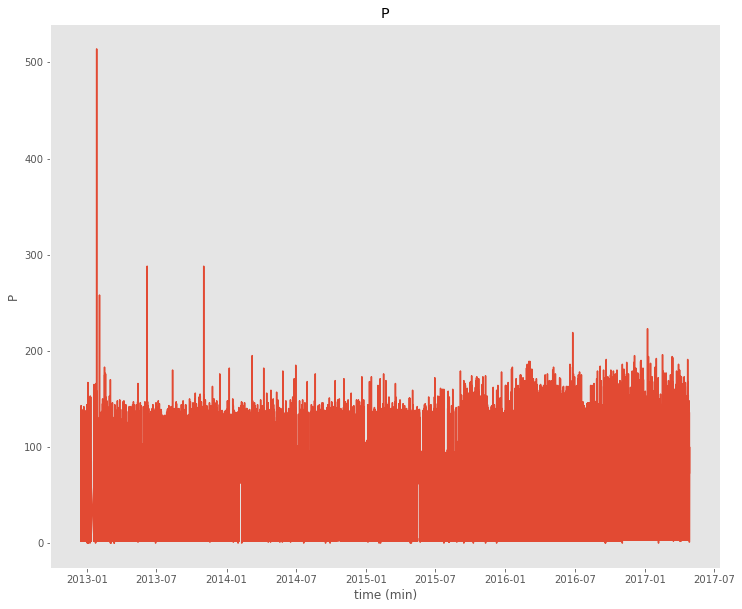

In [22]:
meter = dataset.buildings[1].elec.submeters().meters[7]
dataset.set_window()
df = next(meter.load(physical_quantity='power'))

appliance_metadata = meter.appliances[0].metadata
label = appliance_metadata.get("type")
instance = appliance_metadata.get("instance")
print(label,instance)

#df = df.power.active #for iawe
fig, ax = plt.subplots()
ax.plot(df.fillna(0))
 
ax.set(xlabel='time (min)', ylabel='P', title='P')
ax.grid()

elec = dataset.buildings[2].elec#df.power.active[1900:1950]

In [23]:
ts = df.fillna(0).power.active.values.transpose()

In [25]:
len(ts)

19543268

In [26]:
more = ts[ts > 100]
print(len(more))
print(len(ts))
print("%",100*len(more)/len(ts))

5876
19543268
% 0.030066619359669016


In [182]:
dataset.set_window()
#fridge
meter = dataset.buildings[2].elec.submeters().meters[1]
df = next(meter.load(physical_quantity='power'))

In [8]:
for building in dataset.buildings:
#building = 
        print("------",building)
        count = 0
        for meter in dataset.buildings[building].elec.submeters().meters:
                count += 1
                # get name and instance of an appliance from metadata
                appliance_metadata = meter.appliances[0].metadata
                label = appliance_metadata.get("type")
                instance = appliance_metadata.get("instance")
                print(label,instance,count)
                

------ 1
boiler 1 1
solar thermal pumping station 1 2
laptop computer 1 3
washer dryer 1 4
dish washer 1 5
television 1 6
light 1 7
HTPC 1 8
kettle 1 9
toaster 1 10
fridge freezer 1 11
microwave 1 12
computer monitor 1 13
audio system 1 14
breadmaker 1 15
audio amplifier 1 16
broadband router 1 17
light 3 18
soldering iron 1 19
ethernet switch 1 20
vacuum cleaner 1 21
light 4 22
light 5 23
light 16 24
light 6 25
tablet computer charger 1 26
active subwoofer 1 27
light 7 28
radio 1 29
light 8 30
wireless phone charger 1 31
light 9 32
mobile phone charger 1 33
light 10 34
coffee maker 1 35
radio 2 36
mobile phone charger 2 37
hair dryer 1 38
hair straighteners 1 39
clothes iron 1 40
oven 1 41
computer 1 42
light 11 43
light 12 44
baby monitor 1 45
charger 1 46
light 13 47
light 14 48
light 15 49
desktop computer 1 50
fan 1 51
printer 1 52
------ 2
laptop computer 1 1
computer monitor 1 2
active speaker 1 3
computer 1 4
broadband router 1 5
external hard disk 1 6
kettle 1 7
rice cooker 1 

In [11]:
#for n in range(len(dataset.buildings[building].elec.submeters().meters)):

meter = dataset.buildings[1].elec.submeters().meters[7]
    
# get name and instance of an appliance from metadata
appliance_metadata = meter.appliances[0].metadata
label = appliance_metadata.get("type")
instance = appliance_metadata.get("instance")
print(label,instance)

HTPC 1
